# Setup

In [1]:
# Import needed libraries

from google.colab import drive  # to mount Google Drive to Colab notebook
import tweepy                   # Python wrapper around Twitter API
import json
import pandas as pd
import csv
from datetime import date
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
# Mounting Google Drive

drive.mount('/content/gdrive')
path = './gdrive/My Drive/datasets/twitter_analysis/'

Mounted at /content/gdrive


# Twitter Data Collection

## Log into Twitter API

In [3]:
# Load Twitter API secrets from an external file
# secrets = json.loads(open(path + 'secrets.json').read())  

# consumer_key = secrets['consumer_key']
# consumer_secret = secrets['consumer_secret']
# access_token = secrets['access_token']
# access_token_secret = secrets['access_token_secret']
consumer_key = 'Y8gJE51n85LSida3idV6GYLAo'
consumer_secret = 'nVc3xw7qZ2BAK78XUyVNfPnNGjsIlZS03mPK5PmVtcsQsQSUOK'
access_token = '61239647-XEduA7nTk7GAKCVXjYFUZuq2d6puqbOCkEFdQ2b03'
access_token_secret = 'OiDl8vCSNmxWNtAejJpcQZIVRybImjyWloqaFUnGMyfCR'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Helper Functions

### Save JSON file

In [4]:
# Helper function to save data into a JSON file
# file_name: the name of the data file you want to save on your Google Drive
# file_content: the data you want to save

def save_json(file_name, file_content):
  with open(path + file_name, 'w', encoding='utf-8') as f:
    json.dump(file_content, f, ensure_ascii=False, indent=4)

### Twitter API limit handling

In [5]:
# Helper function to handle twitter API rate limit

def limit_handled(cursor, list_name):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print("\nCurrent number of data points in list = " + str(len(list_name)))
            print('Hit Twitter API rate limit.')
            for i in range(3, 0, -1):
              print("Wait for {} mins.".format(i * 5))
              time.sleep(5 * 60)
        except tweepy.error.TweepError:
            print('\nCaught TweepError exception' )

In [6]:
# update these for whatever tweet you want to process replies to
name = 'malkassabi'
tweet_id = '1212081182365622273'

replies=[]
cursor = tweepy.Cursor(api.search,q='to:'+name, result_type='recent', timeout=999999).items(1000)
for tweet in cursor:
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str==tweet_id):
            replies.append(tweet)

# save_json('replies.json', replies)

with open(path + 'replies.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=('user', 'text'))
    csv_writer.writeheader()
    for tweet in replies:
        print(tweet.user.screen_name)
        row = {'user': tweet.user.screen_name, 'text': tweet.text.encode('ascii', 'ignore').replace('\n', ' ')}
        csv_writer.writerow(row)

In [7]:
len(replies)

0

## Data Collection Functions

### Get all tweets

In [8]:
# Helper function to get all tweets for a specified user
# NOTE:  This method only allows access to the most recent 3240 tweets
# Source: https://gist.github.com/yanofsky/5436496

def get_all_tweets(screen_name):

	# initialize a list to hold all the tweepy Tweets
	alltweets = []	
	
	# make initial request for most recent tweets (200 is the maximum allowed count)
	new_tweets = api.user_timeline(screen_name = screen_name,count=200)
	
	# save most recent tweets
	alltweets.extend(new_tweets)
	
	# save the id of the oldest tweet less one
	oldest = alltweets[-1].id - 1
	
	# keep grabbing tweets until there are no tweets left to grab
	while len(new_tweets) > 0:
		print("getting tweets before %s" % (oldest))
		
		# all subsiquent requests use the max_id param to prevent duplicates
		new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
		
		# save most recent tweets
		alltweets.extend(new_tweets)
		
		# update the id of the oldest tweet less one
		oldest = alltweets[-1].id - 1
		print("...%s tweets downloaded so far" % (len(alltweets)))
	
	# transform the tweepy tweets into a 2D array that will populate the csv	
	outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count, 
	              tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
	
	# write the csv	
	with open(path + '%s_tweets.csv' % screen_name, 'w') as f:
		writer = csv.writer(f)
		writer.writerow(["id","created_at","text","likes","in reply to","retweeted"])
		writer.writerows(outtweets)
	tweets = pd.read_csv(path + '%s_tweets.csv' % screen_name)
	tweets.retweeted = tweets.text.apply(lambda x: True if 'RT @' in x else False)
	tweets['in reply to'] = tweets['in reply to'].fillna('N/A')
	tweets['type'] = tweets['in reply to'].apply(lambda x: 'Tweet' if x == "bloomberg" or x == 'N/A' else 'Reply')
	tweets.loc[tweets.retweeted, 'type'] = 'Retweet'
	tweets.to_csv(path + '%s_tweets.csv' % screen_name)
	pass

### Get today's twitter stats

In [11]:
# Helper function to get today's numbers of followers and friends and store 
# them into a JSON file

def todays_stats(dict_name):
  info = api.me()
  followers_cnt = info.followers_count
  following_cnt = info.friends_count
  today = date.today()
  d = today.strftime("%b %d, %Y")
  if d not in dict_name:
    dict_name[d] = {"followers":followers_cnt, "following":following_cnt}
    save_json("follower_history.json", dict_name)
  else:
    print('Today\'s stats already exist')

### Get followers data

In [12]:
# Helper function to load follower objects into a list and save it into 
# a JSON file. 

def get_followers():
  followers = []

  cursor = tweepy.Cursor(api.followers, count=200).pages()
  for i, page in enumerate(limit_handled(cursor, followers)):
      print("\r"+"Loading"+ i % 5 *".", end='')
      followers += page

  followers = [x._json for x in followers]
  save_json('followers_data.json', followers)

### Get friends data

In [13]:
# Load friends into list

def get_friends():
  friends = []

  for i, page in enumerate(limit_handled(tweepy.Cursor(api.friends, count=200).pages(), friends)):
      print("\r"+"Loading"+ i % 5 *".", end='')
      friends += page

  friends = [x._json for x in friends]
  save_json('friends_data.json', friends)

## Data Collection Main Script

In [14]:
if __name__ == '__main__':
  #pass in the username of the account you want to download
  get_all_tweets("theeconomist")
  # with open(path + 'follower_history.json') as json_file:
  #   history = json.load(json_file)
  # todays_stats(history)
  get_followers()
  get_friends()

getting tweets before 1314276397523894276
...400 tweets downloaded so far
getting tweets before 1313667917112897536
...600 tweets downloaded so far
getting tweets before 1313026155977551871
...800 tweets downloaded so far
getting tweets before 1312461699820077055
...1000 tweets downloaded so far
getting tweets before 1312052504285384703
...1200 tweets downloaded so far
getting tweets before 1311481299102818304
...1400 tweets downloaded so far
getting tweets before 1310882079043977216
...1600 tweets downloaded so far
getting tweets before 1310270235963002882
...1800 tweets downloaded so far
getting tweets before 1309853751822495743
...2000 tweets downloaded so far
getting tweets before 1309487080163209217
...2200 tweets downloaded so far
getting tweets before 1308957603578490880
...2400 tweets downloaded so far
getting tweets before 1308420846801891327
...2600 tweets downloaded so far
getting tweets before 1307862156533211137
...2800 tweets downloaded so far
getting tweets before 130739

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'limit_handled' raised StopIteration
  


Loading

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: generator 'limit_handled' raised StopIteration
  


In [16]:
api.followers()

[User(_api=<tweepy.api.API object at 0x7f12c4f93d30>, _json={'id': 786941656859811840, 'id_str': '786941656859811840', 'name': 'Valentina Pyatkin', 'screen_name': 'valentina__py', 'location': '', 'description': 'PhD Student @biunlp in #NLProc', 'url': 'https://t.co/JtNhYQuNPp', 'entities': {'url': {'urls': [{'url': 'https://t.co/JtNhYQuNPp', 'expanded_url': 'https://valentinapy.github.io', 'display_url': 'valentinapy.github.io', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 433, 'friends_count': 1168, 'listed_count': 4, 'created_at': 'Fri Oct 14 14:48:06 +0000 2016', 'favourites_count': 1078, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 124, 'lang': None, 'status': {'created_at': 'Fri Oct 09 14:00:41 +0000 2020', 'id': 1314566455501955073, 'id_str': '1314566455501955073', 'text': "RT @yanaiela: Super excited to receive the Google PhD Fellowship!\nThank you for the support.\n\nI'm extremel

# Analyzing tweets 

## Load saved data from Google Drive

In [19]:
# Load all saved tweets from @bloomberg
tweets = pd.read_csv(path + 'theeconomist_tweets.csv')

### Classify tweets

In [18]:
# Find the number of tweets in each type
print('Total number of tweets = {}'.format(len(tweets)))
print('\nNumber of tweets by')
tweets.groupby('type').count().id

Total number of tweets = 3239

Number of tweets by


type
Reply        23
Retweet     108
Tweet      3108
Name: id, dtype: int64

In [20]:
# Find the average number of likes per tweet type
tweets.groupby('type').mean().likes

type
Reply      13.913043
Retweet     0.000000
Tweet      80.108430
Name: likes, dtype: float64

In [21]:
# Find and print the top 10 tweets by number of likes
top10 = tweets.sort_values('likes',ascending=False)
top10 = top10.reset_index(drop=True)
top10 = top10.head(10)

for i in range(len(top10)):
  print("{}) At {} likes:".format(i+1, top10.likes[i]))
  print(top10.text[i]+"\n")

1) At 4545 likes:
New Zealand has seen only 25 deaths from covid-19. Many voters feel that Jacinda Ardern has saved them https://t.co/PoOPT43KZc

2) At 3607 likes:
New Zealand has seen only 25 deaths from covid-19. Many voters feel that Jacinda Ardern has saved them https://t.co/3NyBpoo4Qd

3) At 3157 likes:
Minimising further covid-19 deaths is a huge challenge. Judging by this year’s experience, some governments will ha… https://t.co/RXECTexy7o

4) At 3148 likes:
Thanks to Japan's strict recycling culture, less than 5% of the country’s rubbish ends up in landfills https://t.co/ra4qIR4WON

5) At 1845 likes:
At current rates, another 500,000 people are likely to die within the next two and half a months https://t.co/18RAtV2W47

6) At 1070 likes:
New Zealand has seen only 25 deaths from covid-19. Many voters feel that Jacinda Ardern has saved them https://t.co/mTTStb0RN7

7) At 997 likes:
The tally of 32m worldwide cases is an underestimate. Many of the infected do not get sick, and man

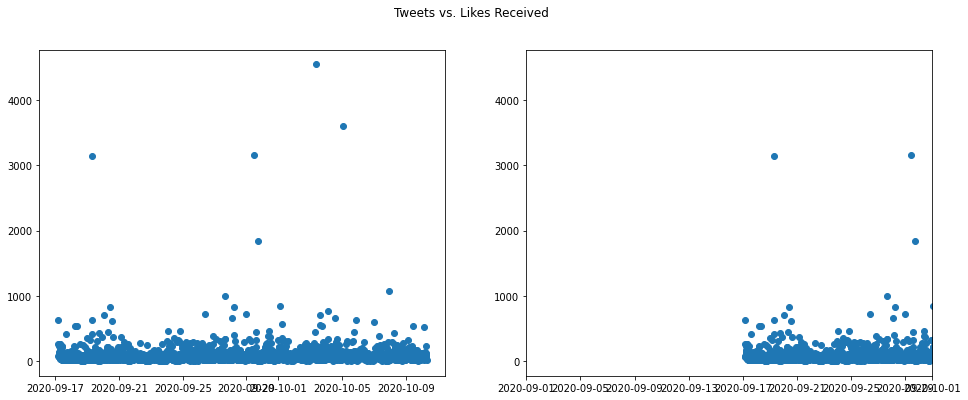

In [22]:
plot_data = tweets[tweets.type == "Tweet"]
plot_data = plot_data[['id','created_at','likes']]
plot_data['time'] = plot_data['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Tweets vs. Likes Received')
ax1.scatter(plot_data.time, plot_data.likes)
ax2.scatter(plot_data.time, plot_data.likes)
left = date(2020, 9, 1)
right = date(2020, 10, 1)
ax2.set_xlim(left=left, right=right);

In [23]:
my_id = plot_data.sort_values('likes',ascending=False).iloc[0]['id']
tweets[tweets['id'] == my_id]['text']

881    New Zealand has seen only 25 deaths from covid...
Name: text, dtype: object

# Doing some NLP as we discussed

In [24]:
import spacy
from collections import Counter
!pip install tweet-preprocessor
import preprocessor as p

In [25]:
nlp = spacy.load("en_core_web_sm")
companies = Counter()
for tweet in tweets.text:
  doc = nlp(p.clean(tweet))
  for ent in doc.ents:
      # print(ent.text, ent.start_char, ent.end_char, ent.label_)
      if ent.label_ == 'ORG':
        companies[ent.text.lower()] += 1

In [ ]:
companies

Counter({'a supreme court': 1,
         'abenomics': 1,
         'abiy': 1,
         'air force': 1,
         'alexa': 4,
         'alexei navalny': 2,
         "alexei navalny's": 2,
         'amazon': 1,
         'america inc': 2,
         'americas': 1,
         'americas department of justice': 1,
         'americas house': 1,
         'americas navy': 2,
         'americas s&amp': 2,
         'americas senate': 1,
         'americas supreme court': 3,
         'amlo': 2,
         'andrea ghez': 1,
         'ant group': 8,
         'apple': 16,
         'argentines': 5,
         'arma': 1,
         'arms': 1,
         'asos': 1,
         'azerbaijan': 1,
         'babbage': 31,
         'babbage podcast:-': 15,
         'barack obama': 1,
         'bbc': 3,
         'bidenomics': 5,
         'big mac': 2,
         'big tobacco': 1,
         'black lives matters': 1,
         'bloomberg': 3,
         'boris johnsons party': 1,
         'borsa': 1,
         'borsa italiana': 1,
     

In [ ]:
nlp = spacy.load("en_core_web_sm")
companies = Counter()
for tweet in tweets.text:
  doc = nlp(p.clean(tweet))
  for ent in doc.ents:
      # print(ent.text, ent.start_char, ent.end_char, ent.label_)
      if ent.label_ == 'ORG':
        companies[ent.text.lower()] += 1

10

#Analyzing followers



##Load Saved data from Google Drive

In [26]:
followers = pd.read_json(path + 'followers_data.json') # Followers User ojbects

In [27]:
df = followers

df = df.fillna('Empty')

df = df.replace('','Empty')

In [28]:
# Create list of tags to identify each location
saudi_tags = ['saudi', 'ksa', 'riyadh', 'jeddah', 'makkah', 'madina', 'dammam', 'khobar', 'السعودية', 'السعوديه', 'جدة', 'الرياض', 'الدمام', 'neom', 'eastern', 'riyad', 'riydah', 'med', 'jed',
              'jubail', 'المدينة', 'ابها', 'مكة', 'sa', 'k.s.a', 'qatif', 'medina', 'tabuk', 'dhahran', 'abha', 'hail', 'qassim', 'mecca', 'ruh', 'buraydah', 'الخبر', 'الشرقية', 'الحجاز', 'بريدة', 'القصيم', 'المملكة العربية', 'جده', 'مكه',
              'الحد_الجنوبي', 'الحرمين', 'نجد', 'الرّس', 'j town', 'جازان', 'unayzah', 'الخُبر', 'الظهران', 'تبوك', 'حائل', 'طيبة', 'المجمعة', 'yanbu', 'taif', 'baljurashi', 'الأحساء', 'jeedah', '966', 'suudi', 'أملج', 'اللهم احفظ بلادي', 'الجبيل',
              'سعودية', 'ينبع', 'ryiadh', 'الطائف', 'jdh', 'Alkharj', 'طويق', 'الباحة', 'أم الملح', 'Al Badai', 'البدائع', 'الدرعيه', 'к.ѕ.α', 'المنوره', 'Abu Arish', 'Alkhober', 'rio', '🇸🇦', 'ام الملح', 'فوق هام السحب']

gulf_tags = ['uae', 'kuwait', 'qatar', 'yemen', 'oman', 'bahrain', 'اليمن', 'الإمارات', 'الكويت', 'قطر', 'البحرين', 'عمان', 'abu dhabi', 'q8', 'الجزيره',
             'dubai', 'الامارات', 'مسقط', 'شبه الجزيرة', 'جزيرة العرب', 'al ain', 'kwt', 'u.a.e', 'حضرموت', 'alain', 'arabian island']

mena_tags = ['egypt', 'مصر', 'libya', 'ليبيا', 'iraq', 'العراق', 'sudan', 'syria', 'jordan', 'الأردن', 'morocco', 'tunisia',
             'algeria', 'mauritania', 'palestine', 'فلسطين', 'cairo', 'gaza', 'الوطن العربي', 'Algiers', 'Marrakech', 'Mansoura', 'Algérie', 'amman', 'rafah', 'الاردن', 'لبنان', 'غزة', 'egy', 'eg', 'سوريا', 'حلب', 'الجزائر',
             'khartoum', 'tunis', 'الإسكندرية', 'السودان', 'lebanon', 'irbid', 'Touggourt', 'ramallah', 'سطيف', 'عمّـان', 'الأسكندرية', 'العالم الإسلامي', 'بلد المليون شهيد', 'MENA']

us_tags = ['us', 'united', 'states', 'usa', 'أمريكا', 'los angeles', 'NY', 'IL', 'DC', 'boston', 'stanford', 'philadelphia', 'CT', 'new orleans', 'miami', 'u.s.a', 'omaha',
           'new york', 'manhattan', 'mn', 'menlo park', 'wa', 'az', 'sf', 'tx', 'pa', 'or', 'portola valley', 'bay area', 'cambridge', 'va', 'fl', 'ga', 'lincoln', 'irvine', 'detroit', 'halifax',
           'ohio', 'nm', 'تكساس', 'co', 'oh', 'nc', 'الامريكية', 'cypress', '92108', 'West Lafayette', 'Utah']

uk_tags = ['uk', 'london', 'leeds', 'new castle', 'manchester', 'liverpool', 'england', 'ireland', 'scotland', 'glasgow']

euro_tags = ['paris', 'france', 'spain', 'munich', 'italy', 'netherlands', 'nederland', 'Deutschland', 'germany', 'berlin', 'finland', 'switzerland', 'sweden', 'stuttgart', 'Malmö', 'Sverige', 'Rotterdam']

canada_tags =['canada', 'british columbia', 'ontario', 'Montréal', 'calgary']

turkey_tags =['turkey', 'Türkiye']

# Create logical masks to clean up data
saudi = df.location.str.contains('|'.join(saudi_tags), case=False)
gulf = df.location.str.contains('|'.join(gulf_tags), case=False)
mena = df.location.str.contains('|'.join(mena_tags), case=False)
us = df.location.str.contains('|'.join(us_tags), case=False)
uk = df.location.str.contains('|'.join(uk_tags), case=False)
euro = df.location.str.contains('|'.join(euro_tags), case=False)
canada = df.location.str.contains('|'.join(canada_tags), case=False)
turkey = df.location.str.contains('|'.join(turkey_tags), case=False)
empty = df.location.str.contains('Empty')
other = saudi | gulf | mena | us | uk | euro | canada | turkey | empty
other = ~other

# Clean up data
df.loc[gulf, 'location'] = 'Gulf'
df.loc[mena, 'location'] = 'MENA'
df.loc[us, 'location'] = 'US'
df.loc[uk, 'location'] = 'UK'
df.loc[euro, 'location'] = 'Europe'
df.loc[canada, 'location'] = 'Canada'
df.loc[turkey, 'location'] = 'Turkey'
df.loc[saudi, 'location'] = 'Saudi Arabia'
df.loc[empty, 'location'] = 'Empty'
df.loc[other, 'location'] = 'Other'

print('Number of unique locations before clean up: ' + str(len(followers.location.unique())))
print('Number of unique locations after clean up: ' + str(len(df.location.unique())))

Number of unique locations before clean up: 1
Number of unique locations after clean up: 1


In [29]:
print('Total number of followers: {}\n'.format(len(followers)))

print('Followers by')
df.groupby('location').count().sort_values('id',ascending=False).id

Total number of followers: 4

Followers by


location
Empty    4
Name: id, dtype: int64

In [30]:
# List the unique locations under Other

ids = df[df.location == 'Other'].id
followers[followers.id.isin(ids)].location.unique()

array([], dtype=object)

In [31]:
print("Number of followers who have more than 30k followers: {}".format(len(df.loc[df.followers_count >= 3e4])))
print('Number of verified followers: {}'.format(len(df[df.verified == True])))

Number of followers who have more than 30k followers: 0
Number of verified followers: 0


# Another Scraping Method

In [33]:
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
  
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
        # consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXX'
        # consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        # access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        # access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXX'
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) 
  
    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
  
    def get_tweets(self, query, count = 10): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 
  
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 
  
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 
  
                # saving text of tweet 
                parsed_tweet['text'] = tweet.text 
                # saving sentiment of tweet 
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
  
                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 
  
            # return parsed tweets 
            return tweets 
  
        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 
  
# creating object of TwitterClient Class 
api = TwitterClient() 
# calling function to get tweets 
tweets = api.get_tweets(query = 'microsoft', count = 1000) 

# picking positive tweets from tweets 
ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
# picking negative tweets from tweets 
ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
# percentage of neutral tweets 
print("Neutral tweets percentage: {} % ".format(100*(len(tweets) -(len( ntweets )+len( ptweets)))/len(tweets))) 

# printing first 5 positive tweets 
print("\n\nPositive tweets:") 
for tweet in ptweets[:10]: 
    print(tweet['text']) 

# printing first 5 negative tweets 
print("\n\nNegative tweets:") 
for tweet in ntweets[:10]: 
    print(tweet['text']) 
  

Positive tweets percentage: 32.142857142857146 %
Negative tweets percentage: 13.095238095238095 %
Neutral tweets percentage: 54.76190476190476 % 


Positive tweets:
RT @cyberomin: Dear @satyanadella, when SARS officials accost a young person, their first point of call is usually your product; Outlook, t…
RT @thereforstarry: 🥞ꔛ🥛♡ อาร์มี่บอมส์ที่ใช้เชื่อมได้จะเป็นเฉพาะ Ver.3 กับ Special Edition น้า 

• Ver.3 ใช้ได้กับ PC / Mac / Android Chrome…
High performance #container networking research with #freeflow leveraging #RDMA https://t.co/wXKq2nzVnv https://t.co/eIAzBe9YL3
RT @AntonyAdshead: @Carhartt shifts old data to the cloud with @Komprise. US-based workwear manufacturer cuts storage costs from $1 to $0.2…
@TC_IntLaw Although I perfectly understand that this problem, I do not see a legal basis for taking action against… https://t.co/4ELnS5INLi
RT @MicrosoftIndia: 29% of workers in India are experiencing increased burnout during the pandemic. New features in #MicrosoftTeams address…
Bil

In [ ]:
len(tweets)

86